In [491]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [492]:
from graphviz import Digraph

def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))


    dot.node(name=uid, label="{%s | data %.4f |grad %.4f}" % (n.label, n.data, n.grad), shape= 'record')
    if n._op:
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op,uid)

  for n1, n2 in edges:
    n1_name = str(id(n1))
    n2_name = str(id(n2))
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot



In [610]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 *out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data *out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad  += other*self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rmul__(self, other):
    return self*other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad  += (1-t**2)*out.grad
    out._backward = _backward

    return out

  def two_tanh(self):
    n = self.tanh()*2
    n.grad = n.grad*2
    return n

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad  += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      a = 1
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [494]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label ='L'

In [495]:
L.grad = 1
f.grad = d.data
d.grad = f.data
c.grad = 1*d.grad
e.grad = 1*d.grad
b.grad = a.data*e.grad
a.grad = b.data*e.grad

In [496]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)
print(L._prev)

-7.286496
{Value(data=-1.96), Value(data=3.7176)}


In [497]:
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0 , label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

o.backward()

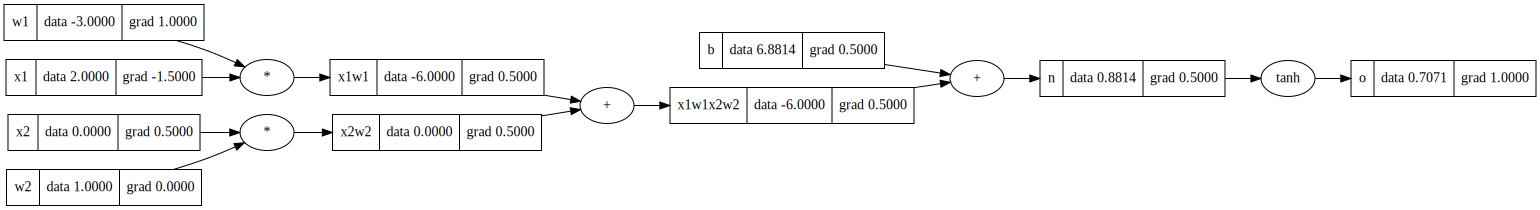

In [498]:
draw_dot(o)

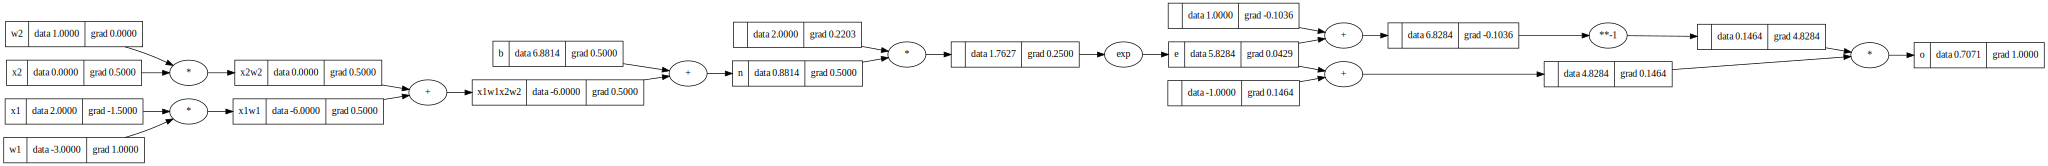

In [499]:
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0 , label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label='e'
g = (e - 1)/(e + 1); g.label='g'

g.label='o'

g.backward()
draw_dot(g)

In [500]:
from torch.storage import T
import torch
import random

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
___
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [625]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.two_tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

def listsum(list):
  sum = 0
  for i in range(0, len(list)):
    sum = list[i] + sum
  return sum

In [513]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9475305024214254)

In [514]:
xs =[
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9475305024214254),
 Value(data=-0.9602512593458459),
 Value(data=0.11474146228507265),
 Value(data=-0.958375416437722)]

In [515]:
for k in range(50):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 *p.grad

  print(k, loss.data)


0 8.872337819690523
1 7.663721261234253
2 7.44974592317025
3 6.867623517723474
4 4.77954176991971
5 3.7876914238187354
6 3.4336403151072448
7 2.379436193895468
8 0.9180575629983481
9 0.17942393458253236
10 0.12665844280818567
11 0.10034448703765633
12 0.08326881019872388
13 0.07106047812346244
14 0.06184980883738331
15 0.05464581685035025
16 0.048859096623224046
17 0.044112696325340386
18 0.04015292151915734
19 0.03680231453496957
20 0.03393287816092087
21 0.03144993117766126
22 0.029281931338414224
23 0.027373824800817584
24 0.025682567681415688
25 0.024174032269287722
26 0.022820821987321636
27 0.021600697934312026
28 0.020495426166963555
29 0.019489920121150885
30 0.018571593698627886
31 0.01772986709647649
32 0.016955784965508324
33 0.016241718252362747
34 0.015581129127981435
35 0.014968383995987333
36 0.01439860351475273
37 0.013867541380934132
38 0.013371485656648249
39 0.012907177910010122
40 0.012471746537980274
41 0.01206265146076761
42 0.011677637994842435
43 0.0113146981809

In [516]:
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
n = MLP(1, [4, 4, 1])

ypred = [n(x) for x in xs]
ypred


[Value(data=0.8189238133145118),
 Value(data=0.8616102661027651),
 Value(data=0.8801937646851282)]

In [ ]:
for k in range(300):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 *p.grad

  if k%5 == 0:
    print(k, loss.data)

  #The network doesnt converge for this step size, it is too large and the
  #network appears confused

In [ ]:
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
m = MLP(1, [4, 4, 1])

ypred = [m(x) for x in xs]
ypred

In [ ]:
for k in range(300):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.02 *p.grad

  if k%5 == 0:
    print(k, loss.data)

  #This step size is better but tanh is bounded between -1 and 1 so the last layer
  # of the network will never output -2 or 2, therefore using tanh() will
  # approach 2  - (-2 - (-1))^2  + (2 - 1)^2

In [622]:
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
nn = MLP(1, [4, 4, 1])

ypred = [nn(x) for x in xs]
ypred

[Value(data=1.7932082186529767),
 Value(data=1.809464344525416),
 Value(data=1.8242037780722953)]

In [626]:
for k in range(300):

  #forward pass
  ypred = [nn(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in nn.parameters():
    p.data += -0.001 *p.grad

  print(k, loss.data)

  #By changing the activiation function to 2*tanh instead of tanh(, the target
  #output values are now in the range of the activation function and the network
  # is able to fully minimize the cost function

0 0.05115185378083798
1 0.05091346476100724
2 0.05067714970247156
3 0.05044288280662917
4 0.05021063868725837
5 0.04998039236252437
6 0.049752119247166215
7 0.04952579514486047
8 0.04930139624075603
9 0.04907889909417873
10 0.048858280631496824
11 0.04863951813914655
12 0.048422589256813815
13 0.048207471970764366
14 0.04799414460732379
15 0.04778258582650063
16 0.04757277461574744
17 0.04736469028386162
18 0.04715831245501613
19 0.0469536210629228
20 0.04675059634511885
21 0.046549218837380946
22 0.04634946936825538
23 0.04615132905370947
24 0.045954779291893934
25 0.04575980175802011
26 0.04556637839934399
27 0.04537449143025772
28 0.045184123327484324
29 0.04499525682537377
30 0.04480787491129875
31 0.044621960821145445
32 0.044437498034899416
33 0.044254470272322925
34 0.044072861488722886
35 0.04389265587080473
36 0.04371383783261348
37 0.04353639201155739
38 0.04336030326451358
39 0.04318555666401226
40 0.04301213749450053
41 0.042840031248680646
42 0.04266922362392292
43 0.04249

In [627]:
ypred

[Value(data=1.8773309429683607),
 Value(data=-0.9914126591978724),
 Value(data=-1.925260435893785)]